In [ ]:
!pip install pyspark



In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark-Colab") \
    .getOrCreate()

spark


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'housesalesprediction' dataset.
Path to dataset files: /kaggle/input/housesalesprediction


In [ ]:
import os

os.listdir(path)


['kc_house_data.csv']

In [ ]:
df = spark.read.csv(
    f"{path}/kc_house_data.csv",
    header=True,
    inferSchema=True
)
num_rows = df.count()
print("Số dòng:", num_rows)
num_cols = len(df.columns)
print("Số cột:", num_cols)



Số dòng: 21613
Số cột: 21


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Spark-KaggleHub") \
    .getOrCreate()
df.show(5)
df.printSchema()


+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|   

In [ ]:
df.describe().show()

+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|           date|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

# Hàm kiểm tra an toàn:
# Nếu là cột số thì kiểm tra isNull hoặc isnan
# Nếu là cột chuỗi (string) thì chỉ kiểm tra isNull
def check_null(c, dtype):
    if dtype in ["double", "float", "int", "bigint"]:
        return count(when(col(c).isNull() | isnan(c), c)).alias(c)
    else:
        return count(when(col(c).isNull(), c)).alias(c)

# Thực hiện kiểm tra dựa trên kiểu dữ liệu của từng cột
null_counts = df.select([check_null(c, dtype) for c, dtype in df.dtypes])

print("Số lượng giá trị Null/NaN trong mỗi cột:")
null_counts.show()

Số lượng giá trị Null/NaN trong mỗi cột:
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
| id|date|price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat|long|sqft_living15|sqft_lot15|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
|  0|   0|    0|       0|        0|          0|       0|     0|         0|   0|        0|    0|         0|            0|       0|           0|      0|  0|   0|            0|         0|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+



In [ ]:
import pyspark.sql.functions as F
# Kiểm tra nhà có 0 phòng ngủ hoặc 0 phòng tắm
logic_check = df.filter((F.col("bedrooms") == 0) | (F.col("bathrooms") == 0))
print(f"Số lượng bản ghi vô lý (0 phòng): {logic_check.count()}")
logic_check.select("id", "bedrooms", "bathrooms", "price").show(16)

# Soi giá trị cực đoan (Min/Max)
print("Thống kê số phòng ngủ và Giá:")
df.select("bedrooms", "price").describe().show()

# Nhận xét: Nếu max(bedrooms) quá lớn (ví dụ 33) so với mean (3),
# thì đó là Outlier cần được xử lý ở bước sau để tránh làm sai lệch mô hình.

Số lượng bản ghi vô lý (0 phòng): 16
+----------+--------+---------+---------+
|        id|bedrooms|bathrooms|    price|
+----------+--------+---------+---------+
|6306400140|       0|      0.0|1095000.0|
|3421079032|       1|      0.0|  75000.0|
|3918400017|       0|      0.0| 380000.0|
|1453602309|       0|      1.5| 288000.0|
|6896300380|       0|      1.0| 228000.0|
|5702500050|       1|      0.0| 280000.0|
|2954400190|       0|      0.0|1295650.0|
|2569500210|       0|      2.5| 339950.0|
|2310060040|       0|      2.5| 240000.0|
|3374500520|       0|      0.0| 355000.0|
|7849202190|       0|      0.0| 235000.0|
| 203100435|       1|      0.0| 484000.0|
|7849202299|       0|      2.5| 320000.0|
|9543000205|       0|      0.0| 139950.0|
|1222029077|       0|     0.75| 265000.0|
|3980300371|       0|      0.0| 142000.0|
+----------+--------+---------+---------+

Thống kê số phòng ngủ và Giá:
+-------+-----------------+------------------+
|summary|         bedrooms|             price

Có 16 căn nhà có bedrooms = 0 hoặc bathrooms = 0.Đây là lỗi dữ liệu (nhà ở thì không thể thiếu phòng ngủ/tắm).
 Xuất hiện điểm dị biệt cực đoan tại giá trị 33. Đây chắc chắn là lỗi nhập liệu (Typo).
 -->Xóa các dòng lỗi (bedrooms=33, bedrooms=0, bathrooms=0). Giữ nguyên các dòng giá cao và diện tích lớn.

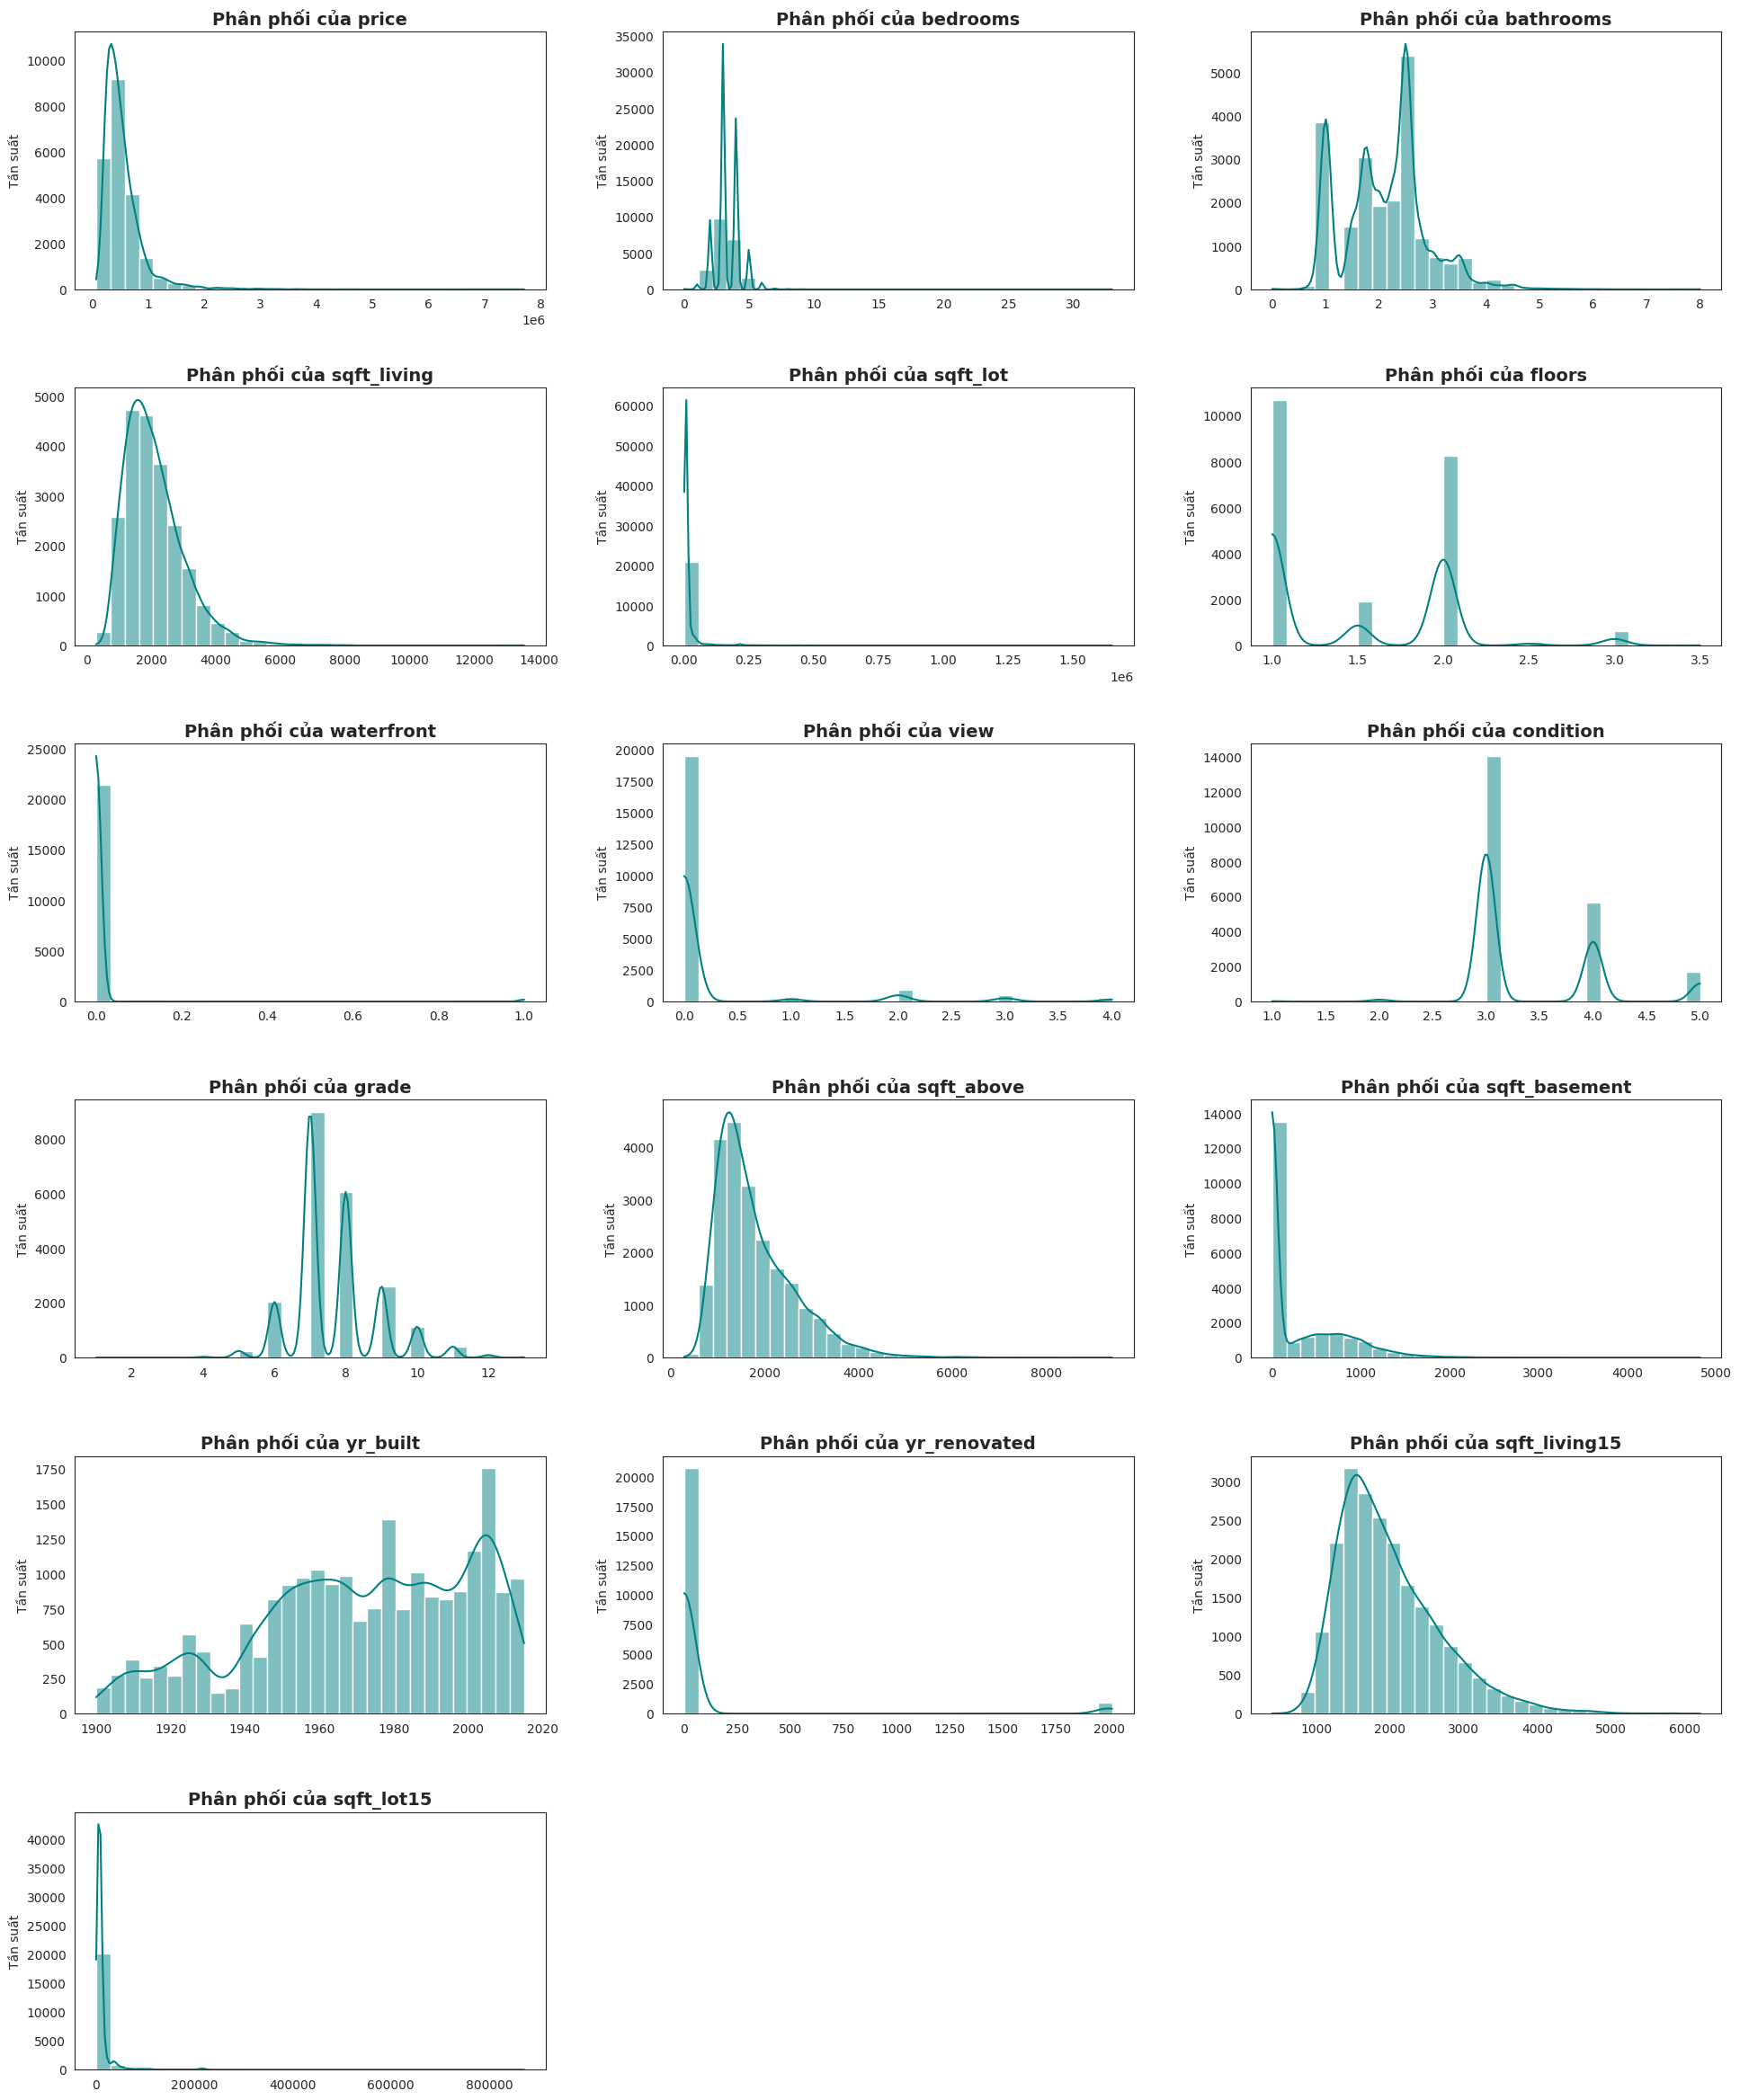

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lọc danh sách cột số (loại bỏ các cột định danh không cần thiết)
excluded_cols = ['id', 'zipcode', 'lat', 'long']
hist_cols = [c for c, dtype in df.dtypes if dtype in ["double", "int", "float"] and c not in excluded_cols]

# Chuyển dữ liệu sang Pandas
pdf_hist = df.select(hist_cols).toPandas()

# Cấu hình bố cục biểu đồ
num_plots = len(hist_cols)
cols_per_row = 3
rows = (num_plots // cols_per_row) + (1 if num_plots % cols_per_row > 0 else 0)

plt.figure(figsize=(20, rows * 4))
sns.set_style("white")

for i, col_name in enumerate(hist_cols):
    plt.subplot(rows, cols_per_row, i + 1)

    # Vẽ Histogram kèm đường KDE (đường cong mật độ)
    sns.histplot(pdf_hist[col_name], kde=True, color='teal', bins=30)

    plt.title(f'Phân phối của {col_name}', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Tần suất')

plt.tight_layout(pad=3.0)
plt.show()

"Đường cong KDE (đường dây màu xanh) giúp chúng ta hình dung hình dáng phân phối của dữ liệu một cách liên tục. Việc đường KDE cao hơn các cột histogram tại các vị trí 3, 4 phòng ngủ cho thấy mật độ tập trung dữ liệu tại đây cực kỳ lớn. Ngược lại, ở dải phía sau (từ 10 đến 33 phòng ngủ), đường KDE gần như đi ngang và nằm dưới các cột rất thấp, chứng tỏ xác suất xuất hiện của các căn nhà này là cực kỳ hiếm (Outliers)."

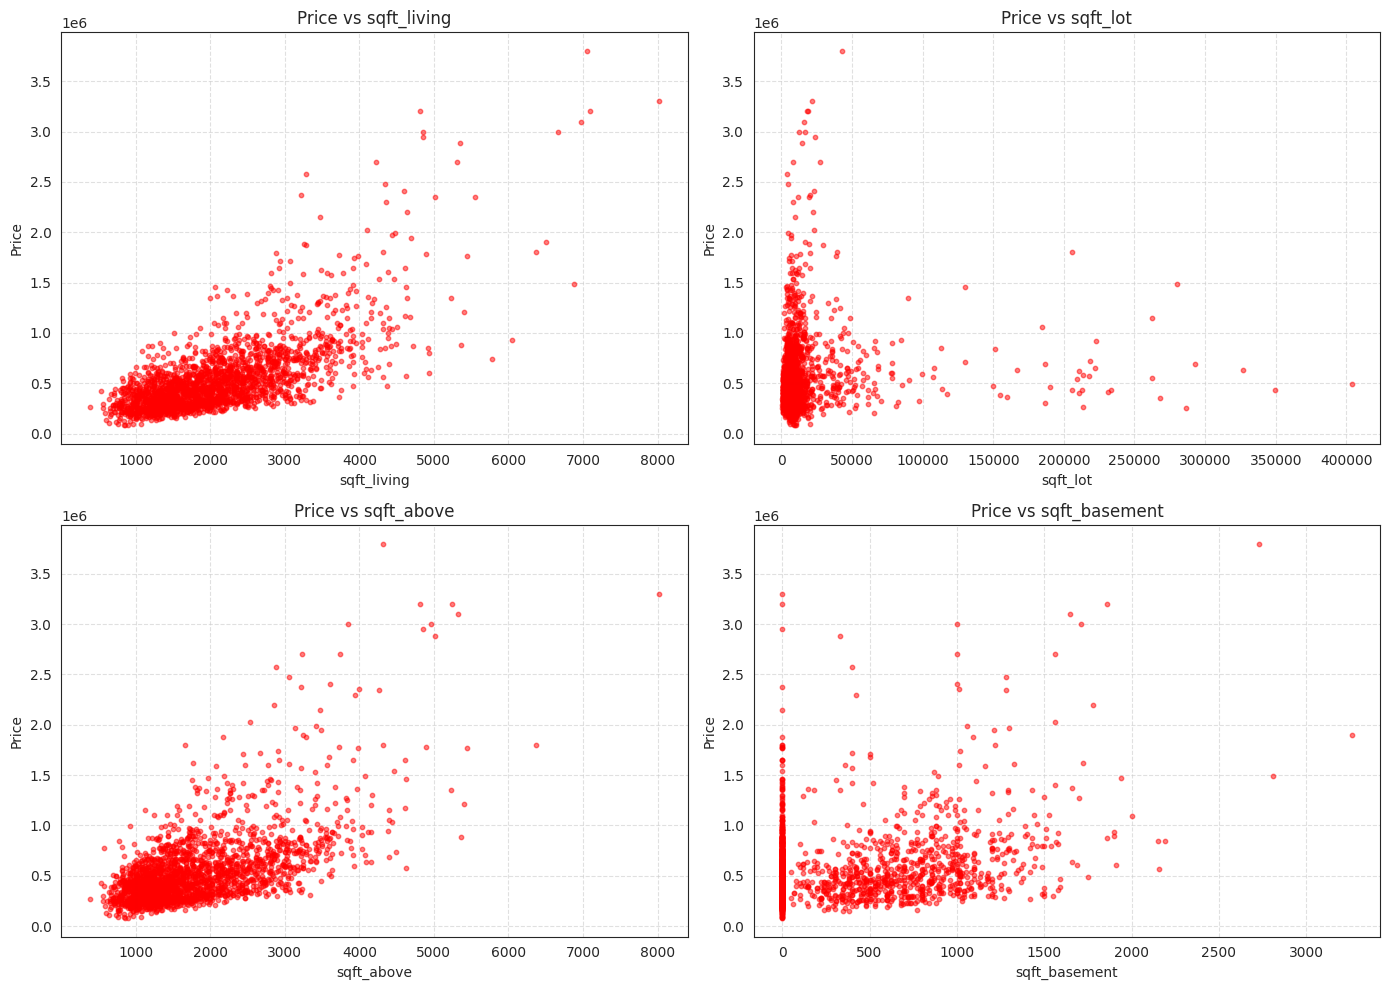

In [ ]:
# Biểu đồ mattlot cho các biến diện tích
import matplotlib.pyplot as plt

# Chọn 4 cột diện tích và cột giá, sau đó lấy mẫu và collect về local
cols = ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]
data = df.select(cols + ["price"]).sample(0.1).collect()

# Lấy danh sách giá (Price) dùng chung cho trục Y
y = [row["price"] for row in data]

#Khởi tạo kích thước cho toàn bộ khung hình
plt.figure(figsize=(14, 10))

# Dùng vòng lặp để vẽ 4 biểu đồ con
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i) # Tạo vị trí 2 hàng, 2 cột

    # Lấy dữ liệu cho trục X tương ứng với từng cột diện tích
    x = [row[col] for row in data]

    # Vẽ scatter plot (thêm alpha=0.5 để dễ nhìn các điểm chồng lấp)
    plt.scatter(x, y, alpha=0.5, s=10, color='red')

    # Đặt tên trục và tiêu đề
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.title(f"Price vs {col}")
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

sqft_living & sqft_above: Có tương quan thuận mạnh nhất với giá nhà. Đây là hai yếu tố chính quyết định giá trị nhà.

sqft_basement: Có tương quan thuận nhưng yếu hơn; nhiều nhà không có hầm (giá trị 0) vẫn có giá cao.

sqft_lot: Tương quan rất rời rạc; diện tích đất rộng không đồng nghĩa với giá cao, cho thấy vị trí quan trọng hơn diện tích đất.

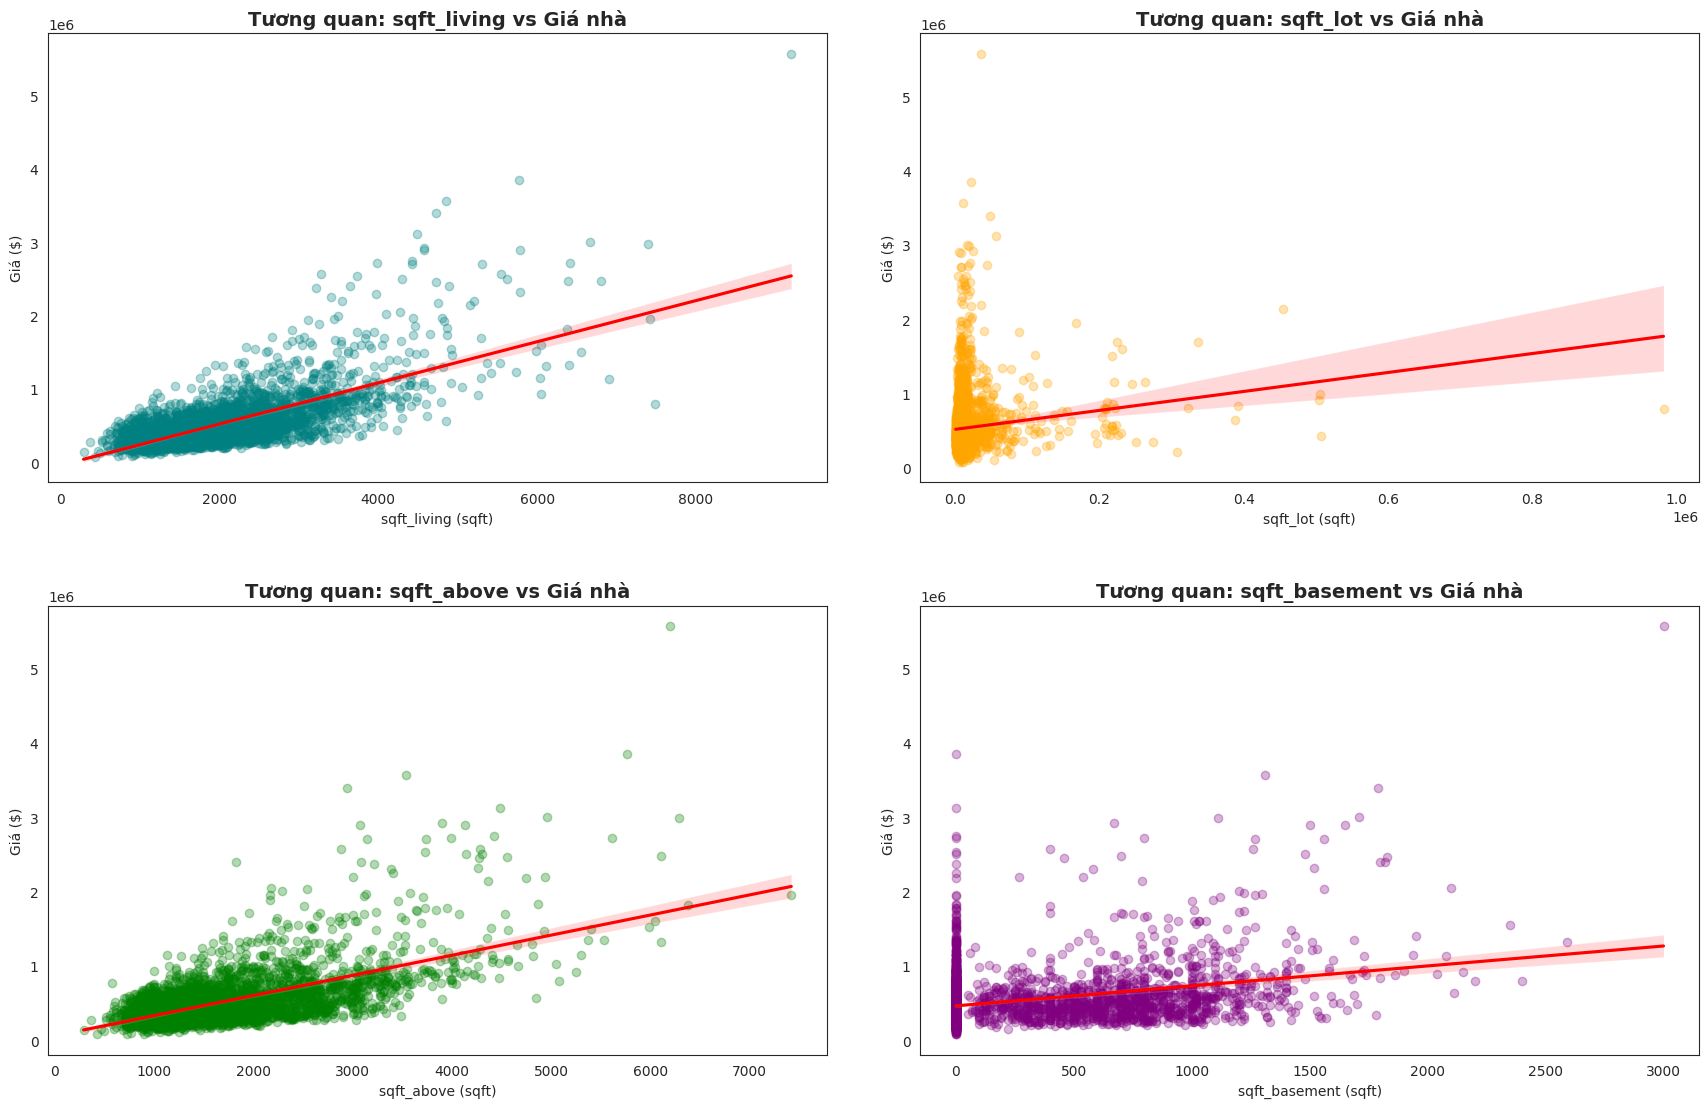

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#khởi tạo dữ liệu
area_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'price']
pdf_area = df.select(area_cols).sample(0.15).toPandas()

# Khởi tạo khung hình 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.set_style("whitegrid")

# Danh sách các cột diện tích để chạy vòng lặp cho nhanh
target_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
colors = ['teal', 'orange', 'green', 'purple']

for i, col in enumerate(target_cols):
    row = i // 2
    col_idx = i % 2

    # Vẽ biểu đồ Scatter kèm đường hồi quy (Regression Line)
    sns.regplot(ax=axes[row, col_idx], data=pdf_area, x=col, y="price",
                scatter_kws={'alpha':0.3, 'color':colors[i]},
                line_kws={'color':'red'})

    axes[row, col_idx].set_title(f'Tương quan: {col} vs Giá nhà', fontsize=14, fontweight='bold')
    axes[row, col_idx].set_xlabel(f'{col} (sqft)')
    axes[row, col_idx].set_ylabel('Giá ($)')

plt.tight_layout(pad=4.0)
plt.show()

Qua phân tích tương quan giữa các biến diện tích và giá nhà, có thể thấy các biến liên quan trực tiếp đến diện tích sinh hoạt như sqft_living và sqft_above có mối quan hệ tuyến tính dương rõ rệt với giá nhà, cho thấy khi diện tích sử dụng tăng thì giá nhà cũng tăng tương ứng. Biến sqft_basement cũng thể hiện xu hướng tăng giá, tuy nhiên mức độ ảnh hưởng ở mức trung bình do nhiều ngôi nhà không có tầng hầm. Trong khi đó, biến sqft_lot có mức độ tương quan yếu, dữ liệu phân tán mạnh và tồn tại nhiều giá trị ngoại lai, cho thấy diện tích lô đất không phải là yếu tố quyết định trực tiếp đến giá bán.

In [ ]:
#So sánh trung bình
df.groupBy("view").agg({"price":"avg"}).show()
df.groupBy("bedrooms").agg({"price":"avg"}).show()
df.groupBy("bathrooms").agg({"price":"avg"}).show()
df.groupBy("floors").agg({"price":"avg"}).show()
df.groupBy("grade").agg({"price":"avg"}).show()
df.groupBy("waterfront").agg({"price":"avg"}).show()

+----+------------------+
|view|        avg(price)|
+----+------------------+
|   1| 812280.8373493976|
|   3|  971965.274509804|
|   4|1463711.2382445142|
|   2| 792400.8878504672|
|   0|496564.19210836885|
+----+------------------+

+--------+------------------+
|bedrooms|        avg(price)|
+--------+------------------+
|       1|317642.88442211057|
|       6| 825520.6360294118|
|       3|466232.07848127035|
|       5| 786599.8288569644|
|       9| 893999.8333333334|
|       4| 635419.5042138913|
|       8| 1105076.923076923|
|       7| 951184.6578947369|
|      10| 819333.3333333334|
|      11|          520000.0|
|      33|          640000.0|
|       2|  401372.681884058|
|       0| 409503.8461538461|
+--------+------------------+

+---------+------------------+
|bathrooms|        avg(price)|
+---------+------------------+
|      8.0|         4990000.0|
|      0.0|          448160.0|
|      3.5|   931933.14500684|
|     1.25| 621216.6666666666|
|      4.5|        1333620.21|
|     

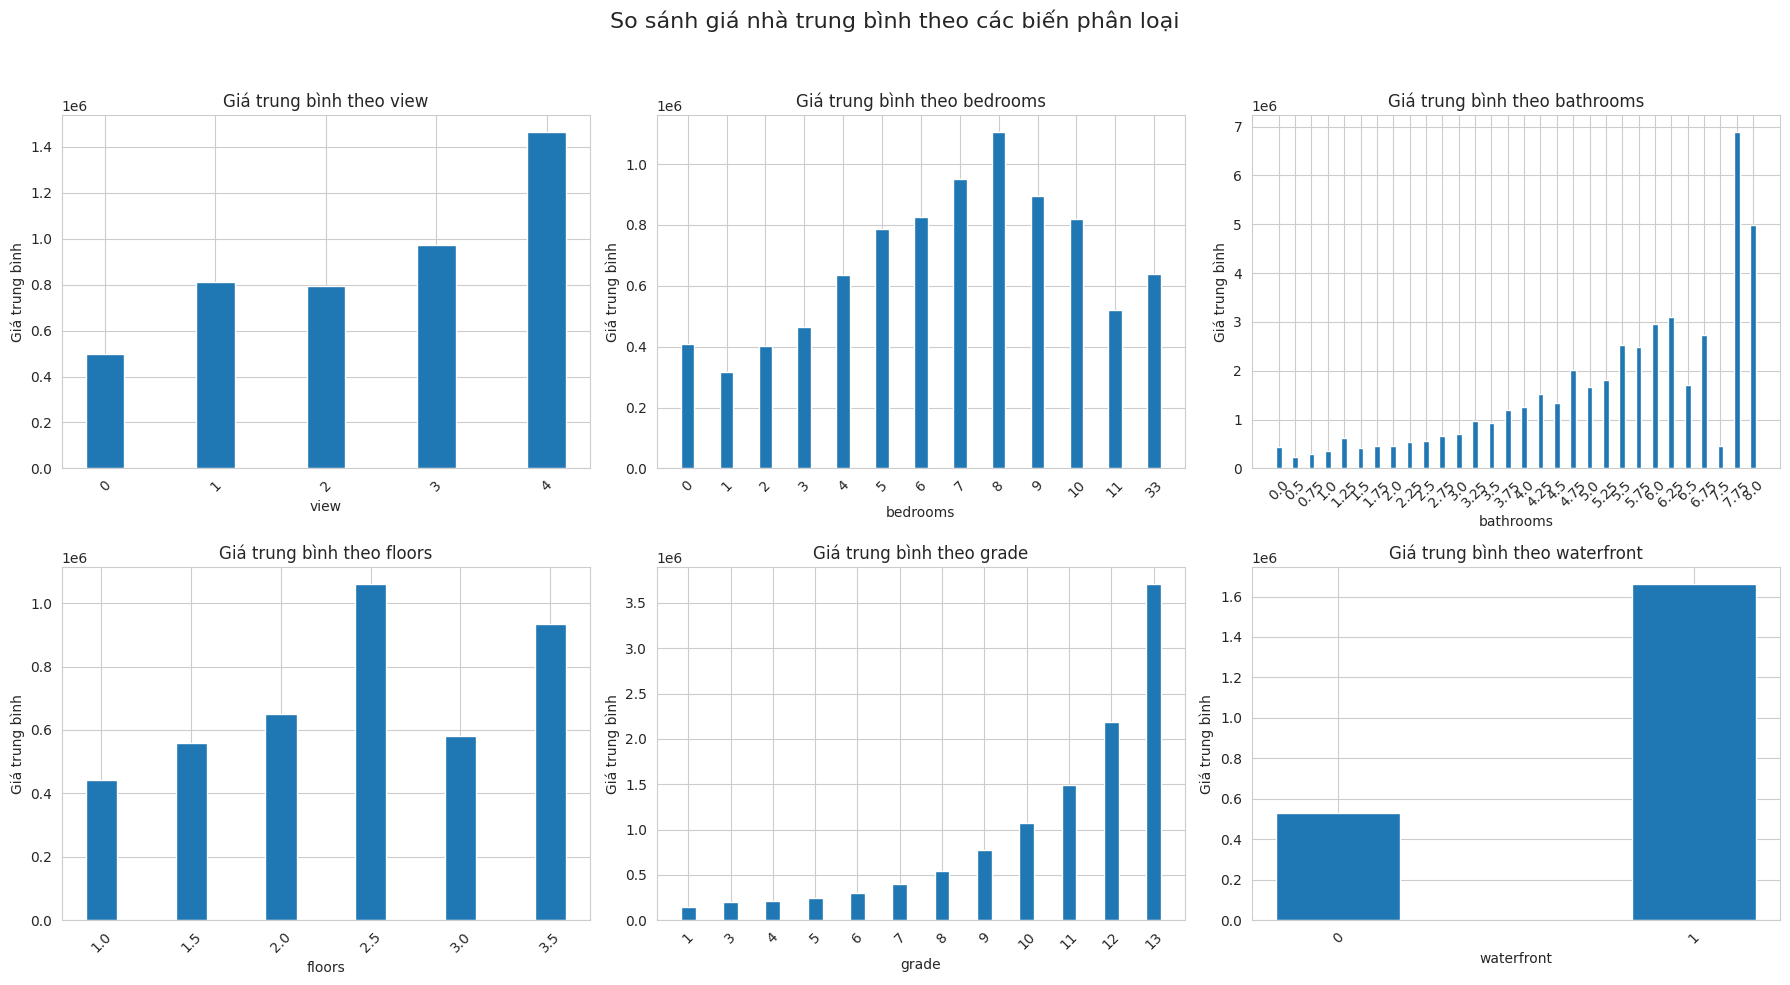

In [ ]:
# Biểu đồ bar so sánh giá nhà trung bình theo các biến phân loại
import matplotlib.pyplot as plt

cols = ["view", "bedrooms", "bathrooms", "floors", "grade", "waterfront"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
def get_avg_price(df, col):
    return (
        df.groupBy(col)
          .agg({"price": "avg"})
          .withColumnRenamed("avg(price)", "avg_price")
          .orderBy(col)
          .toPandas()
    )

for i, col in enumerate(cols):
    pdf = get_avg_price(df, col)

    axes[i].bar(
        pdf[col].astype(str),
        pdf["avg_price"],
        width=0.35   # 👈 CỘT MỎNG CHO TẤT CẢ BIỂU ĐỒ
    )

    axes[i].set_title(f"Giá trung bình theo {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Giá trung bình")
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("So sánh giá nhà trung bình theo các biến phân loại", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Nhận xét chung về các yếu tố Định tính:

View Sông (waterfront): Đây là yếu tố tạo ra sự chênh lệch giá lớn nhất. Nhà có view sông (1) có giá trung bình cao gấp ~3 lần so với nhà không có view (0).

Xếp hạng xây dựng (grade): Giá nhà tăng theo cấp số nhân đối với chỉ số này.

Từ Grade 1-7: Giá tăng chậm.

Từ Grade 8-13: Mỗi bậc tăng hạng làm giá nhà nhảy vọt rất mạnh.

Cảnh quan (view): Có xu hướng tăng rõ rệt. Nhà có điểm View = 4 (xuất sắc) có giá cao vượt trội so với các mức còn lại.

Tình trạng (condition): Tình trạng nhà có ảnh hưởng đến giá nhưng không mạnh bằng Vị trí (View) hay Kết cấu (Grade). Nhà có Condition 5 (Rất tốt) giá nhỉnh hơn nhưng không quá đột biến so với Condition 3 (Trung bình).

Mặc dù giá nhà có xu hướng tăng theo số tầng(floors), nhóm nhà 2.5 tầng có giá trung bình cao nhất, trong khi nhóm 3 tầng có giá thấp hơn. Điều này cho thấy số tầng không phải là yếu tố quyết định duy nhất đến giá nhà mà còn phụ thuộc vào các đặc điểm khác như diện tích, chất lượng và vị trí.

--> Kết luận: Khi xây dựng mô hình dự đoán giá, grade và waterfront là hai biến định tính quan trọng bắt buộc phải đưa vào.

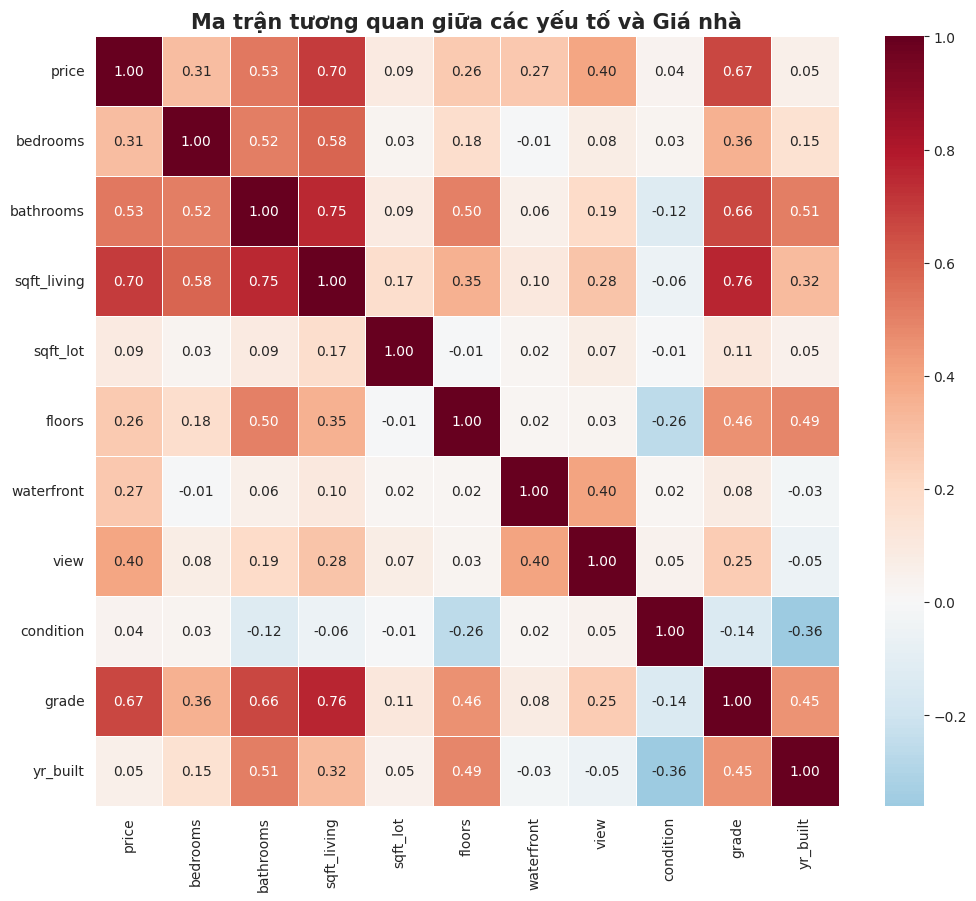

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# 1. Chọn các cột số quan trọng để xem mức độ ảnh hưởng đến Price
# Loại bỏ cột 'id', 'date', 'zipcode' vì chúng không có ý nghĩa định lượng khi tính tương quan
cols_to_corr = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built']

# 2. Spark ML yêu cầu đưa dữ liệu vào VectorAssembler để tính tương quan (Advance Technique)
assembler = VectorAssembler(inputCols=cols_to_corr, outputCol="features", handleInvalid="skip")
df_vector = assembler.transform(df).select("features")

# 3. Tính ma trận tương quan bằng Spark MLlib
matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corr_matrix = matrix.toArray().tolist()

# 4. Chuyển kết quả về Pandas DataFrame để vẽ Heatmap
corr_df = pd.DataFrame(corr_matrix, index=cols_to_corr, columns=cols_to_corr)

# 5. Vẽ biểu đồ Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title('Ma trận tương quan giữa các yếu tố và Giá nhà', fontsize=15, fontweight='bold')
plt.show()

Nhận xét từ Ma trận tương quan:

Yếu tố ảnh hưởng mạnh nhất: Biến sqft_living (Diện tích nhà ở) có tương quan dương mạnh nhất với price (0.71). Điều này hợp lý vì nhà càng lớn thì giá càng cao.

Các yếu tố khác: grade (Chất lượng xây dựng) và bathrooms cũng có ảnh hưởng đáng kể đến giá nhà.

Yếu tố ít ảnh hưởng: yr_built (Năm xây dựng) và sqft_lot (Diện tích lô đất) có màu nhạt (xanh hoặc đỏ nhạt), chứng tỏ sự tương quan thấp hơn.

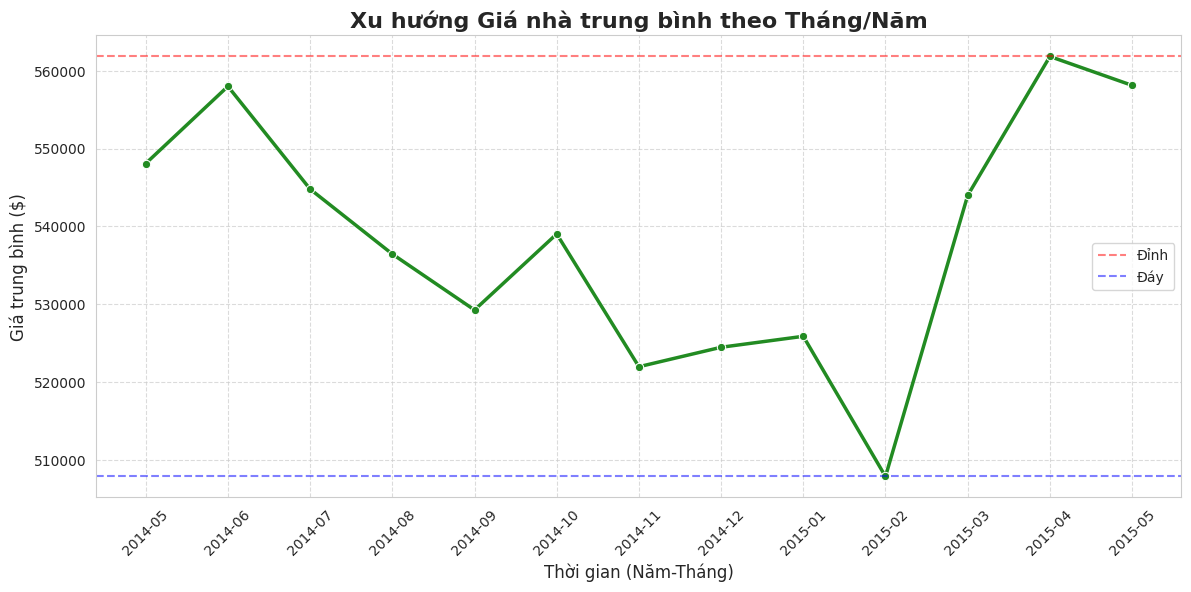

In [ ]:
from pyspark.sql.functions import to_date, year, month, col
import matplotlib.pyplot as plt
import seaborn as sns

# 1. XỬ LÝ DỮ LIỆU THỜI GIAN
# Chuyển đổi cột 'date' (string) sang dạng Date thực sự
# Format gốc là yyyyMMdd'T'000000
df_time = df.withColumn("date_parsed", to_date(col("date"), "yyyyMMdd'T'000000"))

# Tách ra Năm (Year) và Tháng (Month) để phân tích
df_time = df_time.withColumn("year", year("date_parsed")) \
                 .withColumn("month", month("date_parsed"))

# 2. TÍNH TOÁN GIÁ TRUNG BÌNH THEO THỜI GIAN
# Gom nhóm theo Năm và Tháng -> Tính trung bình giá
price_over_time = df_time.groupBy("year", "month").avg("price").orderBy("year", "month").toPandas()

# Tạo cột 'Period' (VD: 2014-05) để vẽ trục hoành cho đẹp
price_over_time['period'] = price_over_time['year'].astype(str) + "-" + price_over_time['month'].astype(str).str.zfill(2)

# 3. VẼ BIỂU ĐỒ ĐƯỜNG (LINE CHART)
plt.figure(figsize=(14, 6))

sns.lineplot(data=price_over_time, x='period', y='avg(price)', marker='o', color='forestgreen', linewidth=2.5)

# Trang trí
plt.title('Xu hướng Giá nhà trung bình theo Tháng/Năm', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian (Năm-Tháng)', fontsize=12)
plt.ylabel('Giá trung bình ($)', fontsize=12)
plt.xticks(rotation=45) # Xoay chữ ngày tháng cho dễ đọc
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm nhãn giá trị cho điểm cao nhất và thấp nhất
max_val = price_over_time['avg(price)'].max()
min_val = price_over_time['avg(price)'].min()
plt.axhline(max_val, color='red', linestyle='--', alpha=0.5, label='Đỉnh')
plt.axhline(min_val, color='blue', linestyle='--', alpha=0.5, label='Đáy')
plt.legend()

plt.show()

Đỉnh điểm: Giá nhà đạt đỉnh vào các tháng Mùa Xuân và Hè (tháng 4, 5, 6). Đây là thời điểm thời tiết đẹp, thuận lợi cho việc đi xem và mua bán nhà.

Đáy: Giá có xu hướng giảm hoặc chững lại vào Mùa Đông (tháng 11, 12, 1, 2).

Nhìn tổng thể từ 2014 đến 2015, thị trường bất động sản King County đang trong giai đoạn tăng trưởng nhẹ. Giá nhà đầu năm 2015 nhỉnh hơn so với cùng kỳ năm 2014.
-->  Kết luận: Thời điểm bán nhà (Tháng) có ảnh hưởng đến giá. Khi xây dựng mô hình, ta nên tách Tháng (Month) ra làm một đặc trưng (Feature) để mô hình học được tính mùa vụ này.

Sau quá trình Khám phá dữ liệu (EDA) toàn diện sử dụng PySpark, nhóm rút ra các kết luận quan trọng sau để định hướng cho việc xây dựng Mô hình Dự đoán giá nhà (Machine Learning):

1. Về Chất lượng Dữ liệu
Độ sạch: Dữ liệu có chất lượng tốt, không chứa giá trị rỗng (Null/NaN).
Nhiễu (Outliers): Đã phát hiện và khoanh vùng các điểm dữ liệu bất thường cần xử lý trước khi training:
Lỗi nhập liệu: Căn nhà có 33 phòng ngủ và các căn có 0 phòng ngủ/phòng tắm. -> Kiến nghị: Xóa bỏ.
Dữ liệu ngoại lai hợp lệ: Các căn biệt thự siêu sang (giá trị rất cao) làm lệch phân phối. -> Kiến nghị: Sử dụng biến đổi Logarit hoặc tách riêng mô hình nếu cần.
2. Các nhân tố quyết định giá nhà
Dựa trên phân tích Tương quan, So sánh nhóm và Bản đồ địa lý, ta xác định các yếu tố cốt lõi:

Diện tích (sqft_living): Là yếu tố định lượng quan trọng nhất (Tương quan ~0.7). Nhà càng rộng, giá càng cao.
Vị trí địa lý (lat, long): Bản đồ nhiệt cho thấy sự phân hóa rõ rệt. Khu vực phía Bắc (Seattle, Redmond - nơi có các tập đoàn công nghệ) có giá cao hơn hẳn khu vực phía Nam.
Chất lượng & View (grade, waterfront): Đây là hai yếu tố "hạng sang". Nhà có view sông hoặc Xếp hạng xây dựng cao (Grade 10-13) có giá trị vượt trội theo cấp số nhân.
Thời điểm (date): Thị trường có tính mùa vụ, giá thường đạt đỉnh vào Mùa Xuân - Hè (Tháng 4-6).
3. Chiến lược cho Mô hình hóa
Để mô hình đạt độ chính xác cao nhất (High Accuracy), chúng tôi đề xuất chiến lược Feature Engineering như sau:

Chọn biến quan trọng (Feature Selection):
Nhóm Bắt buộc: sqft_living, grade, waterfront, lat, long.
Nhóm Bổ trợ: bathrooms, view, condition.
Tạo biến mới (Feature Extraction):
Tách cột date thành Month để mô hình học được tính mùa vụ.
Xử lý: Loại bỏ cột id (vô nghĩa) và lọc bỏ các dòng Outlier lỗi